# import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


2026-01-01 11:18:15.007107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767266295.190542      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767266295.243263      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767266295.672126      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767266295.672168      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767266295.672170      55 computation_placer.cc:177] computation placer alr

# Paths & Hyperparameters

In [3]:
TRAIN_PATH = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_PATH  = '/kaggle/input/brain-tumor-mri-dataset/Testing'

IMG_SIZE   = (299, 299)
BATCH_SIZE = 32
EPOCHS     = 10
SEED       = 42

# Prepare DataFrame

In [4]:
def create_dataframe(directory: str) -> pd.DataFrame:
    data = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                data.append({
                    "filepath": os.path.join(class_dir, file),
                    "label": label
                })
    return pd.DataFrame(data)

train_df = create_dataframe(TRAIN_PATH)
test_df  = create_dataframe(TEST_PATH)

valid_df, test_df = train_test_split(
    test_df,
    train_size=0.5,
    stratify=test_df['label'],
    random_state=SEED
)

# Image Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.8, 1.2)
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Build Model

In [6]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
    pooling='max'
)
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name="precision"), Recall(name="recall")]
)


I0000 00:00:1767266319.043845      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1767266327.184731     123 service.cc:152] XLA service 0x78dca8004bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767266327.184771     123 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767266328.415593     123 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767266340.795722     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6472 - loss: 1.0707 - precision: 0.6875 - recall: 0.5932

2026-01-01 11:20:32.804565: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 11:20:33.041774: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 11:20:34.011006: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 11:20:34.272162: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 545ms/step - accuracy: 0.6476 - loss: 1.0689 - precision: 0.6880 - recall: 0.5937 - val_accuracy: 0.8473 - val_loss: 0.4009 - val_precision: 0.8727 - val_recall: 0.8061
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.8246 - loss: 0.4779 - precision: 0.8531 - recall: 0.7956 - val_accuracy: 0.8687 - val_loss: 0.3554 - val_precision: 0.8843 - val_recall: 0.8519
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.8560 - loss: 0.3971 - precision: 0.8740 - recall: 0.8374 - val_accuracy: 0.8595 - val_loss: 0.3540 - val_precision: 0.8758 - val_recall: 0.8397
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.8687 - loss: 0.3477 - precision: 0.8880 - recall: 0.8487 - val_accuracy: 0.8565 - val_loss: 0.3356 - val_precision: 0.8756 - val_recall: 0.8382
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.8758 - loss: 0.3404 - precision: 0.8875 - recall: 0.8579 - val_accuracy: 0.8626 - val_los

# Evaluate


In [8]:
def evaluate_model(model, generator, name):
    score = model.evaluate(generator, verbose=0)
    print(f"{name} Accuracy: {score[1]*100:.2f}%")

evaluate_model(model, train_gen, "Train")
evaluate_model(model, val_gen,   "Validation")
evaluate_model(model, test_gen,  "Test")

Train Accuracy: 94.50%
Validation Accuracy: 91.60%
Test Accuracy: 91.01%


# Confusion Matrix & Classification Report

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 629ms/step


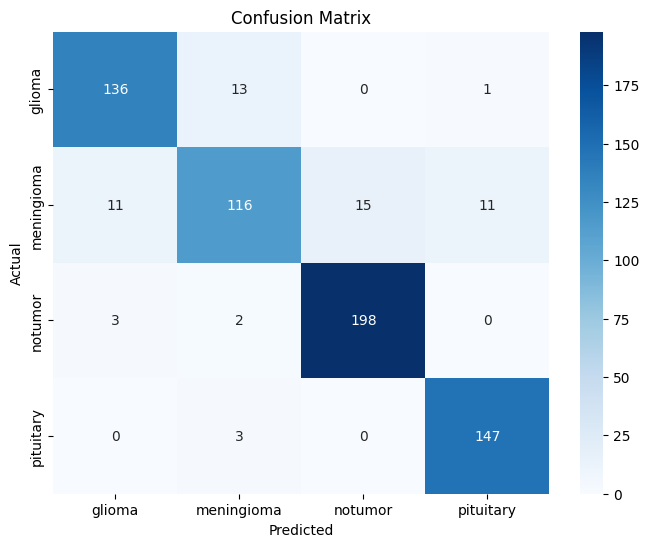

              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91       150
  meningioma       0.87      0.76      0.81       153
     notumor       0.93      0.98      0.95       203
   pituitary       0.92      0.98      0.95       150

    accuracy                           0.91       656
   macro avg       0.91      0.91      0.90       656
weighted avg       0.91      0.91      0.91       656



In [9]:
y_probs = model.predict(test_gen)
y_pred  = np.argmax(y_probs, axis=1)
y_true  = test_gen.classes
CLASS_NAMES  = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Save TFLite Model

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = "/kaggle/working/brain_tumor_model_lite.tfliteA"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print(f" Lite model saved: {tflite_path}")

INFO:tensorflow:Assets written to: /tmp/tmpdm8m07j8/assets


INFO:tensorflow:Assets written to: /tmp/tmpdm8m07j8/assets


Saved artifact at '/tmp/tmpdm8m07j8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_133')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132895294786256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125954704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125958736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125958352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125955088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125958928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125957392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125959504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125959120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132892125957200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1328921259

W0000 00:00:1767267394.875550      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767267394.875582      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


 Lite model saved: /kaggle/working/brain_tumor_model_lite.tfliteA


# Test Predictions Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


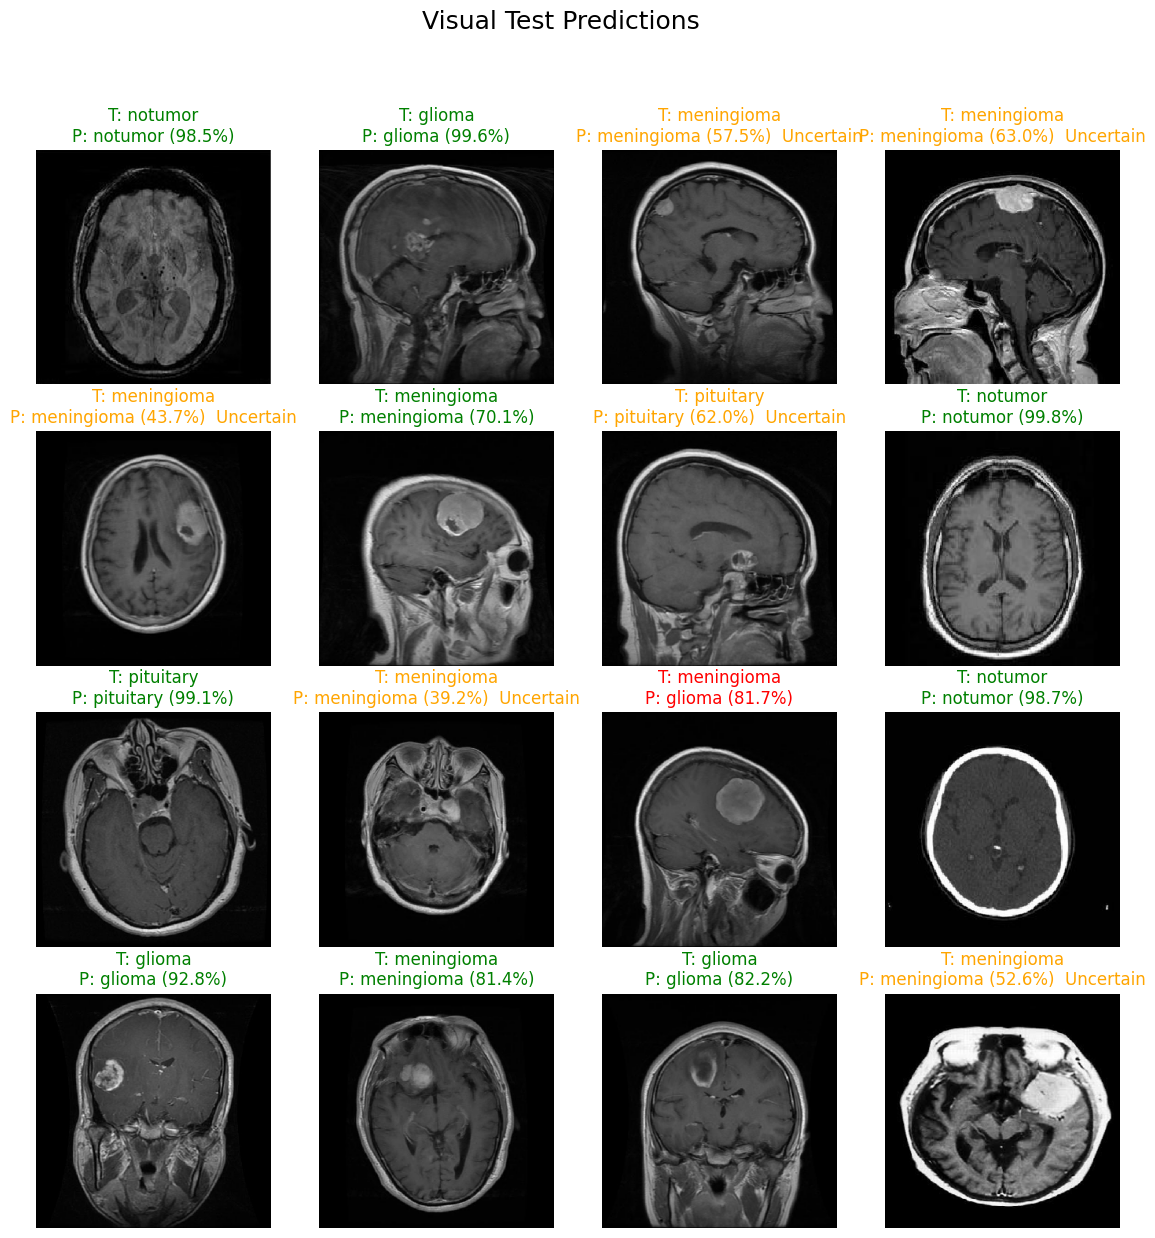

In [12]:
def visualize_test_predictions(generator, model, n=16, threshold=0.7):
    images, labels = next(generator)
    preds = model.predict(images)
    class_labels = list(generator.class_indices.keys())
    plt.figure(figsize=(14, 14))
    
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[np.argmax(labels[i])]
        pred_label_idx = np.argmax(preds[i])
        pred_label = class_labels[pred_label_idx]
        confidence = preds[i][pred_label_idx]

        # Check if confidence is low -> mark as uncertain
        if confidence < threshold:
            color = 'orange'
            title_text = f"T: {true_label}\nP: {pred_label} ({confidence*100:.1f}%)  Uncertain"
        else:
            color = 'green' if true_label == pred_label else 'red'
            title_text = f"T: {true_label}\nP: {pred_label} ({confidence*100:.1f}%)"

        plt.title(title_text, color=color)
        plt.axis('off')
    
    plt.suptitle("Visual Test Predictions", fontsize=18)
    plt.show()

visualize_test_predictions(test_gen, model)